# Similarity-Based Remaining Useful Life Estimation

## Data Preparation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model  import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

from scipy.signal import savgol_filter

In [ ]:
dataset = pd.read_csv('RUL/Thuy/train.txt', sep=' ', header=None,
                  names=['op_setting_1','op_setting_2','op_setting_3',
                        'sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9','sensor_10',
                        'sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16','sensor_17','sensor_18','sensor_19','sensor_20','sensor_21','sensor_22','sensor_23'])
dataset.info()

In [22]:
dataset=dataset.drop(['sensor_22','sensor_23'], axis=1)
dataset.reset_index(inplace=True)
dataset.rename(columns={'level_0':'id','level_1':'time'}, inplace=True)

NameError: name 'dataset' is not defined

In [125]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
id,45918.0,109.396511,62.866193,1.0000,54.000000,110.0000,164.0000,218.0000
time,45918.0,110.307396,68.420545,1.0000,53.000000,106.0000,160.0000,357.0000
op_setting_1,45918.0,24.008881,14.793676,0.0000,10.004500,25.0015,41.9981,42.0080
op_setting_2,45918.0,0.571251,0.310935,0.0000,0.250600,0.7000,0.8400,0.8420
op_setting_3,45918.0,49.172438,32.503659,0.0000,20.000000,40.0000,80.0000,100.0000
sensor_1,45918.0,472.861677,26.460179,445.0000,445.000000,462.5400,491.1900,518.6700
sensor_2,45918.0,579.596770,37.391068,535.6500,549.580000,555.9850,607.3700,644.4300
sensor_3,45918.0,1419.947816,106.286960,1245.4300,1352.910000,1369.1400,1499.6975,1614.6600
sensor_4,45918.0,1205.669194,119.550936,1029.4900,1124.010000,1138.8700,1307.4375,1442.3600
sensor_5,45918.0,8.029878,3.627125,3.9100,3.910000,7.0500,10.5200,14.6200


In [126]:
dataset.head()

,id,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


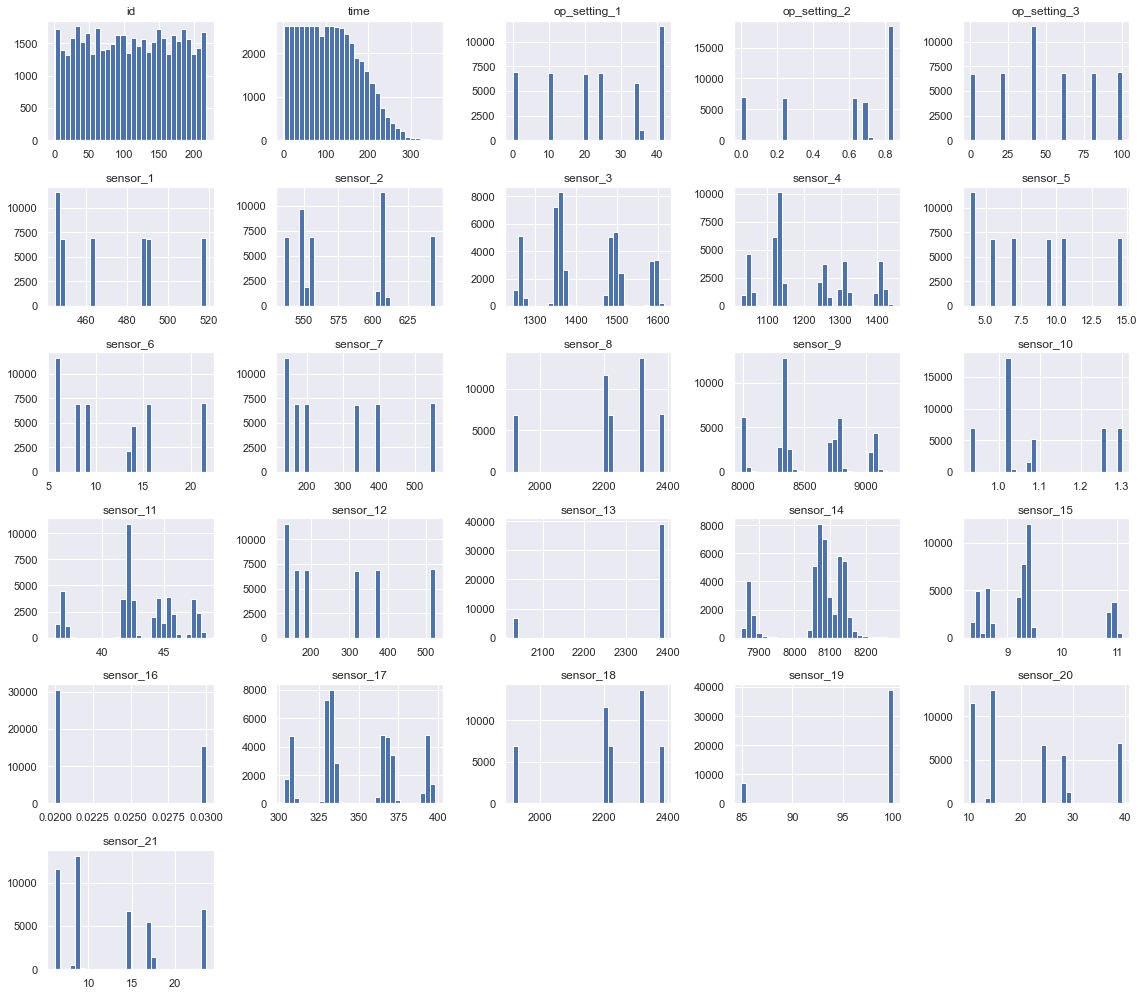

In [127]:
sns.set(font_scale=1) 
dataset.hist(bins=30, figsize=(16,14), color='b')
plt.tight_layout()
plt.show()

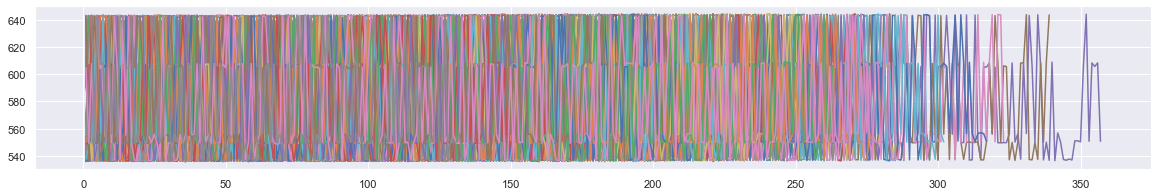

In [128]:
fig = plt.figure(figsize=(20,3))
for i in dataset.id.unique():
    plt.plot(dataset[dataset.id == i].time, dataset[dataset.id == i].sensor_2)
plt.show()

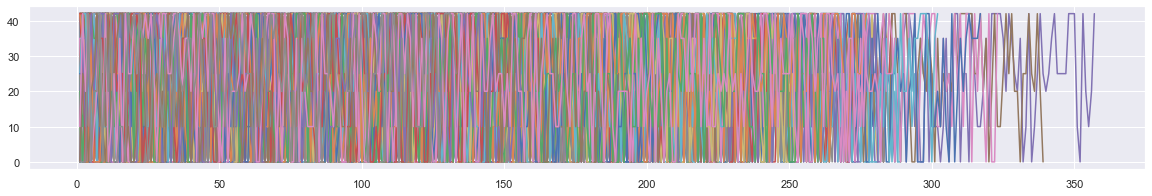

In [129]:
fig = plt.figure(figsize=(20,3))
for i in dataset.id.unique():
    plt.plot(dataset[dataset.id == i].time, dataset[dataset.id == i].op_setting_1)
plt.show()

In [130]:
df_train = dataset.copy()
sc = StandardScaler()
df_train.iloc[:,2:] = sc.fit_transform(df_train.iloc[:,2:])

In [131]:
df_train.head()

,id,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.946643,-1.032868,-0.897522,0.611806,0.656133,0.748004,0.872280,0.686535,...,0.768710,0.420047,0.650649,-0.945475,1.407518,0.707902,0.622252,0.419844,0.787914,0.792209
1,1,2,-1.622831,-1.836260,1.563766,1.731236,1.672429,1.548675,1.658648,1.816919,...,1.851930,0.420203,0.792357,-1.252594,1.407518,1.534132,1.095853,0.419844,1.839048,1.833696
2,1,3,0.742874,0.864655,0.333122,-0.885177,-0.646599,-0.487156,-0.695771,-0.703010,...,-0.598451,0.418646,-0.020113,0.030948,-0.710470,-0.513481,-0.036671,0.419844,-0.600471,-0.607683
3,1,4,-0.270780,0.415682,-1.512844,0.692683,0.733692,0.644415,0.363956,0.363962,...,0.353908,0.419580,-0.155936,-0.145423,-0.710470,0.564210,0.656571,0.419844,0.367864,0.389929
4,1,5,1.216426,0.865941,-0.282200,-1.052978,-0.804393,-0.615960,-0.680464,-1.135865,...,-0.980756,0.418179,0.213283,-0.045001,-0.710470,-0.657173,-0.112172,0.419844,-0.988210,-1.020514


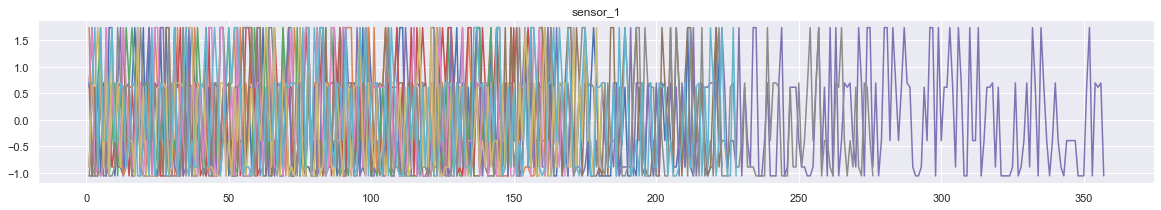

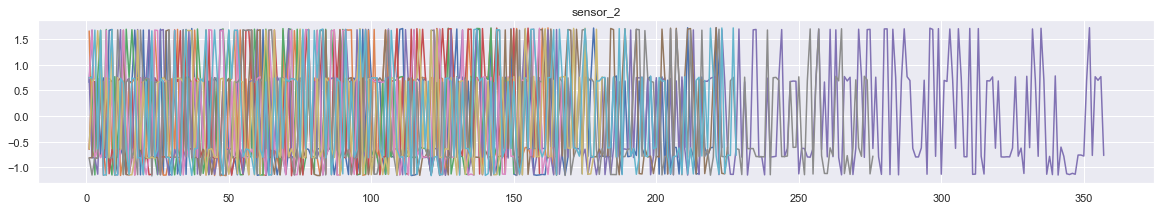

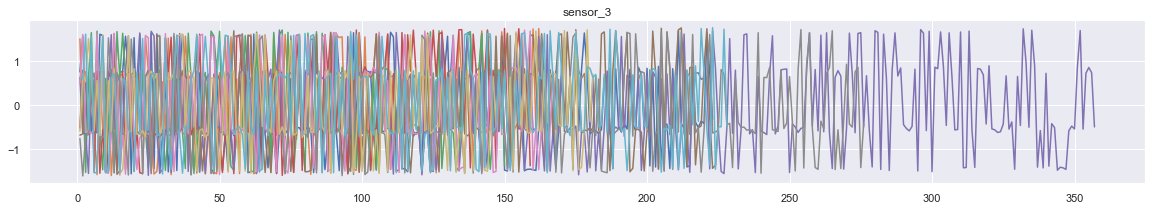

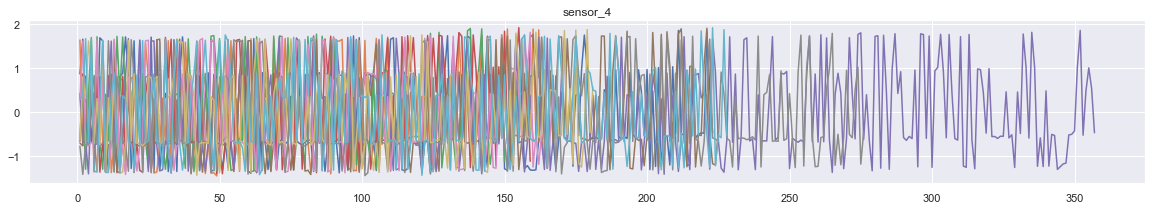

In [132]:
def vis_data(data,list_sensor,nsample):
    start = data.id.unique()[0]
    for x in list_sensor:
        fig = plt.figure(figsize=(20,3))
        plt.title(x)
        
        for i in range(start,start+nsample):
            plt.plot(data[data.id == i].time, data[data.id == i][x])
        plt.show()
    
vis_data(df_train,['sensor_1','sensor_2','sensor_3','sensor_4'],10)

# Data Preparation

In [133]:
degradationData = dataset.copy()
degradationData.head(8)

,id,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025
5,1,6,20.0032,0.7017,0.0,491.19,607.37,1480.46,1258.90,9.35,...,315.36,2388.05,8053.17,9.2276,0.02,364,2324,100.0,24.44,14.7019
6,1,7,41.9998,0.8400,40.0,445.00,549.57,1354.43,1131.44,3.91,...,130.16,2387.88,8082.01,9.3753,0.02,331,2212,100.0,10.53,6.4254
7,1,8,0.0011,0.0000,100.0,518.67,642.08,1589.55,1407.59,14.62,...,521.74,2388.03,8133.29,8.4339,0.03,391,2388,100.0,38.98,23.2337


In [134]:
degradationData.id.unique

<bound method Series.unique of 0          1
1          1
2          1
3          1
4          1
        ... 
45913    218
45914    218
45915    218
45916    218
45917    218
Name: id, Length: 45918, dtype: int64>

In [135]:
trainData = degradationData[degradationData.id <= 175].copy()
validationData = degradationData[degradationData.id > 175].copy()
trainData.shape, validationData.shape

((36953, 26), (8965, 26))

In [136]:
varNames = dataset.columns.values
timeVariable = varNames[1]
conditionVariables = varNames[2:5]
dataVariables = varNames[5:]
timeVariable, conditionVariables, dataVariables

('time',
 array(['op_setting_1', 'op_setting_2', 'op_setting_3'], dtype=object),
 array(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
        'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
        'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
        'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
        'sensor_21'], dtype=object))

# Working Regime Clustering

In [137]:
opConditionUnwrap = trainData[conditionVariables]

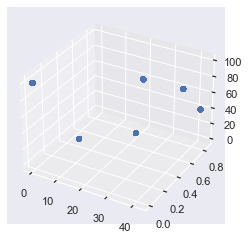

In [138]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(trainData[conditionVariables[0]],trainData[conditionVariables[1]],trainData[conditionVariables[2]])
plt.show()

In [139]:
kmeans = KMeans(n_clusters=6, random_state = 0)
kmeans.fit(opConditionUnwrap)
y_means = kmeans.predict(opConditionUnwrap)
#opConditionUnwrap['cluster'] = y_means

In [140]:
trainData['cluster'] = y_means
opConditionUnwrap_data = trainData[np.concatenate([dataVariables,['cluster']])].copy()
opConditionUnwrap_data.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,cluster
0,489.05,604.13,1499.45,1309.95,10.52,15.49,394.88,2318.87,8770.20,1.26,...,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735,1
1,518.67,642.13,1584.55,1403.96,14.62,21.61,553.67,2388.01,9045.76,1.30,...,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619,3
2,449.44,555.42,1368.17,1122.49,5.48,8.00,194.93,2222.86,8343.91,1.02,...,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555,5
3,491.19,607.03,1488.44,1249.18,9.35,13.65,334.82,2323.85,8721.53,1.08,...,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832,4
4,445.00,549.52,1354.48,1124.32,3.91,5.71,138.24,2211.80,8314.56,1.02,...,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025,2


In [141]:
centerstats_Mean = opConditionUnwrap_data.groupby('cluster').mean()
centerstats_Mean

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
cluster,,,,,,,,,,,,,,,,,,,,,
0,462.54,536.866022,1262.757144,1050.476105,7.05,9.027578,175.393618,1915.403369,8014.905016,0.939892,...,164.563229,2028.301014,7877.963863,10.914911,0.020000,307.372072,1915.0,84.93,14.262658,8.556490
1,489.05,604.915092,1502.118228,1311.278176,10.52,15.493282,394.330771,2318.960574,8784.210247,1.260000,...,371.444292,2388.163177,8134.003351,8.665071,0.030000,369.720556,2319.0,100.00,28.525602,17.115649
2,445.00,549.715303,1354.621466,1128.135490,3.91,5.715838,138.626119,2211.957558,8327.346362,1.020228,...,130.537990,2388.036854,8088.751540,9.376569,0.020000,331.109504,2212.0,100.00,10.583779,6.351372
3,518.67,642.706013,1590.674154,1409.381296,14.62,21.609862,553.313525,2388.102883,9062.697514,1.300000,...,521.364739,2388.104143,8141.257203,8.443833,0.030000,393.248389,2388.0,100.00,38.810936,23.286003
4,491.19,607.595361,1486.008519,1253.603141,9.35,13.656846,334.458211,2324.023035,8729.449879,1.077642,...,314.848950,2388.156385,8065.318794,9.234914,0.022319,365.426422,2324.0,100.00,24.448859,14.670421
5,449.44,555.820024,1366.862711,1131.763863,5.48,8.000297,194.435873,2223.023608,8355.262185,1.020315,...,183.014876,2388.120191,8071.277797,9.333748,0.020000,334.258552,2223.0,100.00,14.828883,8.897827


In [142]:
centerstats_std = opConditionUnwrap_data.groupby('cluster').std()
centerstats_std

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.353349,5.278598,6.883058,0.0,0.004305,0.448665,0.264980,14.214266,0.001034,...,0.341990,0.279569,13.166653,0.043721,0.000000,1.314260,0.0,0.0,0.111936,0.066923
1,0.0,0.473666,5.819018,8.335675,0.0,0.004696,0.655193,0.094242,17.954677,0.000000,...,0.524908,0.095907,15.898738,0.037491,0.000000,1.470130,0.0,0.0,0.144385,0.086245
2,0.0,0.441707,5.663650,7.573173,0.0,0.004929,0.443624,0.303788,18.210528,0.001493,...,0.341671,0.327705,16.742747,0.036987,0.000000,1.410423,0.0,0.0,0.107826,0.063664
3,0.0,0.488569,5.948333,8.822452,0.0,0.001166,0.861418,0.068744,20.108024,0.000000,...,0.714143,0.069433,17.222070,0.036629,0.000000,1.500148,0.0,0.0,0.175289,0.105220
4,0.0,0.468204,5.765488,7.851966,0.0,0.004659,0.602514,0.131173,18.161187,0.004245,...,0.491484,0.133730,15.952062,0.038042,0.004221,1.443815,0.0,0.0,0.133579,0.080284
5,0.0,0.439361,5.671460,7.332927,0.0,0.001697,0.477076,0.287052,17.491366,0.001746,...,0.378257,0.308188,15.813069,0.038240,0.000000,1.393185,0.0,0.0,0.111971,0.069366


The statistics in each regime can be used to normalize the training data. For each ensemble member, extract the **operating points** of each row, compute its distance to each cluster centers and find the nearest cluster center. Then, for each **sensor** measurement, subtract the mean and divide it by the standard deviation of that cluster. If the standard deviation is close to 0, set the normalized sensor measurement to 0 because a nearly constant sensor measurement is not useful for remaining useful life estimation.

In [143]:
def regimeNormalization(data):
    list_df = []
    Clusters = data.cluster.unique()
    for cluster in Clusters:
        each_cluster = data[data.cluster == cluster].copy()
        sc = StandardScaler()
        each_cluster.loc[:, dataVariables] = sc.fit_transform(each_cluster.loc[:,dataVariables])
        list_df.append(each_cluster)
    res_df = pd.concat(list_df)
    res_df.sort_values(by = ['id','time'], inplace=True)
    return res_df

In [144]:
trainDataNormalized = regimeNormalization(trainData)
trainDataNormalized.head()

,id,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,cluster
0,1,1,10.0047,0.2501,20.0,-1.136868e-13,-1.657632,-0.458577,-0.159351,1.776357e-15,...,-0.345965,-0.828653,-1.159613,-6.938894e-18,-1.170449,0.0,0.0,0.376795,0.670828,1
1,1,2,0.0015,0.0003,100.0,0.000000e+00,-1.179085,-1.029650,-0.614544,0.000000e+00,...,0.660509,-0.487047,-1.450701,-1.040834e-17,-1.498912,0.0,0.0,1.021627,0.721385,3
2,1,3,34.9986,0.8401,60.0,5.684342e-14,-0.910551,0.230524,-1.264803,-8.881784e-16,...,-0.552282,-0.470400,0.574104,3.469447e-18,-0.185600,0.0,0.0,0.009978,-0.610253,5
3,1,4,20.0031,0.7005,0.0,5.684342e-14,-1.207623,0.421769,-0.563368,1.776357e-15,...,-0.646026,-0.816195,-0.310591,-5.495079e-01,-0.988044,0.0,0.0,-0.216062,1.404888,4
4,1,5,42.0041,0.8405,40.0,0.000000e+00,-0.442178,-0.024979,-0.503844,1.776357e-15,...,-0.448154,-0.303523,-2.108147,0.000000e+00,-0.786688,0.0,0.0,3.767566,0.803141,2


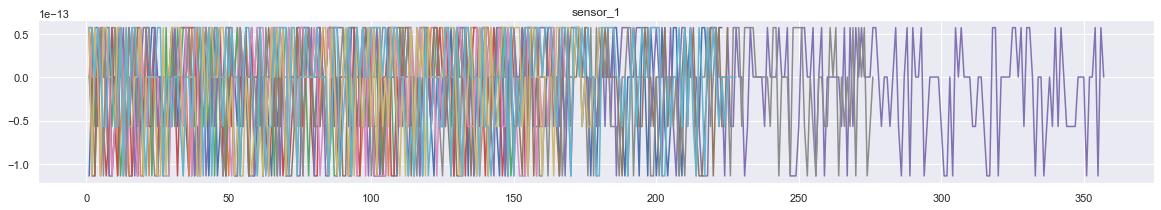

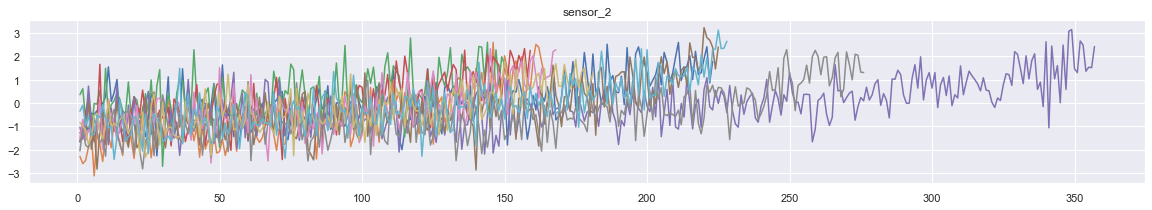

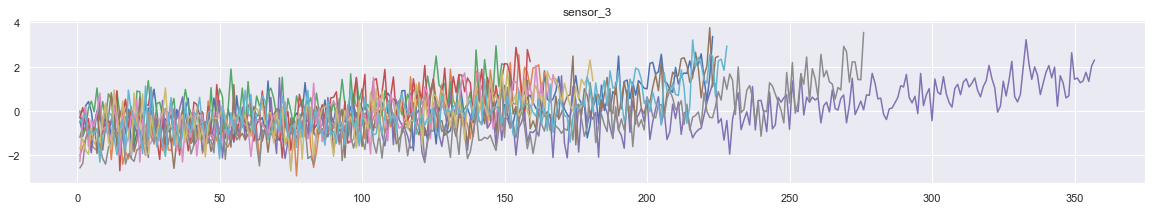

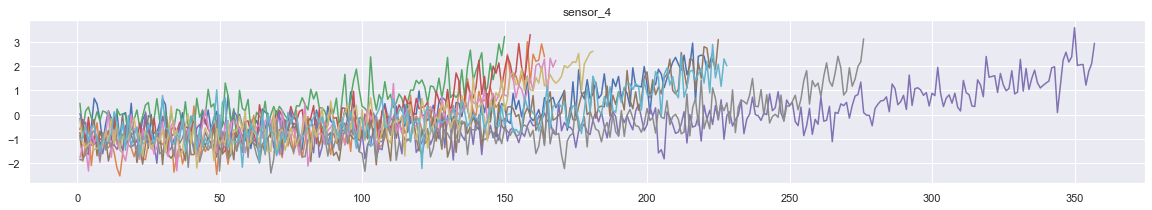

In [145]:
vis_data(trainDataNormalized,dataVariables[:4],10)

# Trendability Analysis

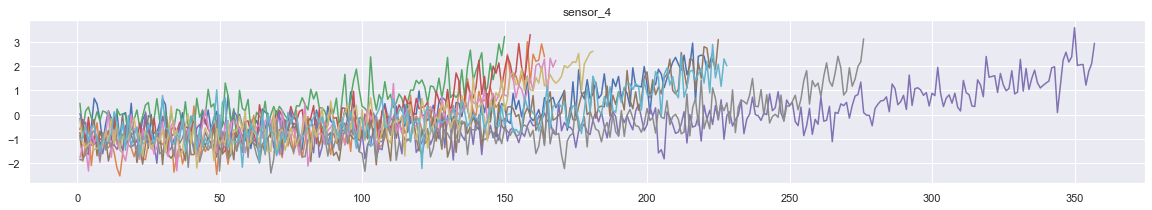

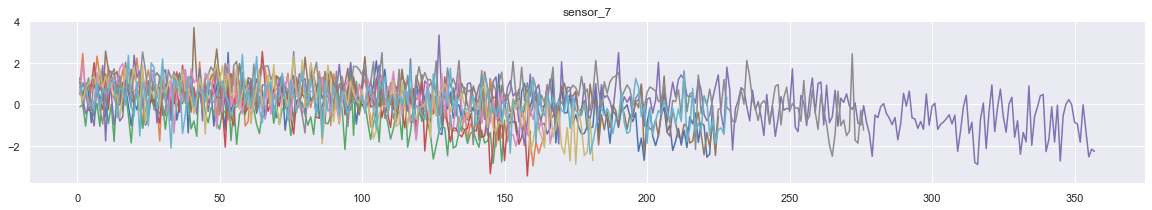

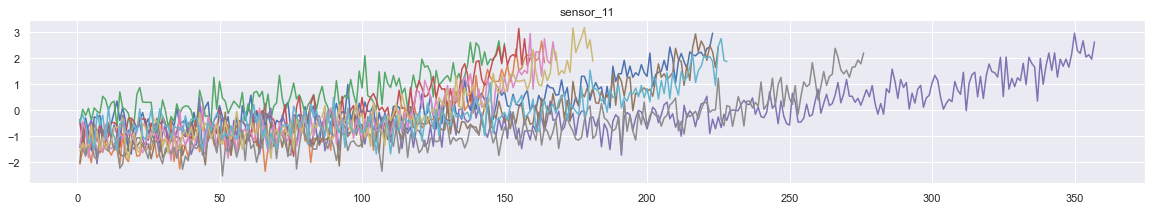

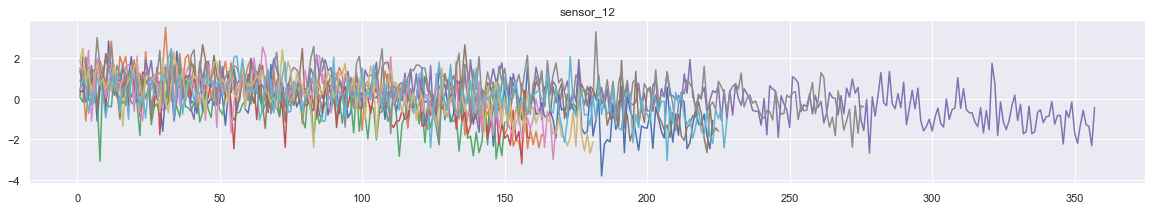

In [146]:
vis_data(trainDataNormalized,['sensor_4','sensor_7','sensor_11','sensor_12'],10)

# Construct Health Indicator

In [147]:
ids = trainDataNormalized.id.unique()
list_df = []
for idx in ids:
    each_idx = trainDataNormalized[trainDataNormalized.id == idx].copy()
    rul = len(each_idx)
    each_idx['health'] = each_idx.apply(lambda x: 1- (x.time/rul) , axis=1)
    list_df.append(each_idx)
trainDataNormalized = pd.concat(list_df)
trainDataNormalized.head()

,id,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,cluster,health
0,1,1,10.0047,0.2501,20.0,-1.136868e-13,-1.657632,-0.458577,-0.159351,1.776357e-15,...,-0.828653,-1.159613,-6.938894e-18,-1.170449,0.0,0.0,0.376795,0.670828,1,0.995516
1,1,2,0.0015,0.0003,100.0,0.000000e+00,-1.179085,-1.029650,-0.614544,0.000000e+00,...,-0.487047,-1.450701,-1.040834e-17,-1.498912,0.0,0.0,1.021627,0.721385,3,0.991031
2,1,3,34.9986,0.8401,60.0,5.684342e-14,-0.910551,0.230524,-1.264803,-8.881784e-16,...,-0.470400,0.574104,3.469447e-18,-0.185600,0.0,0.0,0.009978,-0.610253,5,0.986547
3,1,4,20.0031,0.7005,0.0,5.684342e-14,-1.207623,0.421769,-0.563368,1.776357e-15,...,-0.816195,-0.310591,-5.495079e-01,-0.988044,0.0,0.0,-0.216062,1.404888,4,0.982063
4,1,5,42.0041,0.8405,40.0,0.000000e+00,-0.442178,-0.024979,-0.503844,1.776357e-15,...,-0.303523,-2.108147,0.000000e+00,-0.786688,0.0,0.0,3.767566,0.803141,2,0.977578


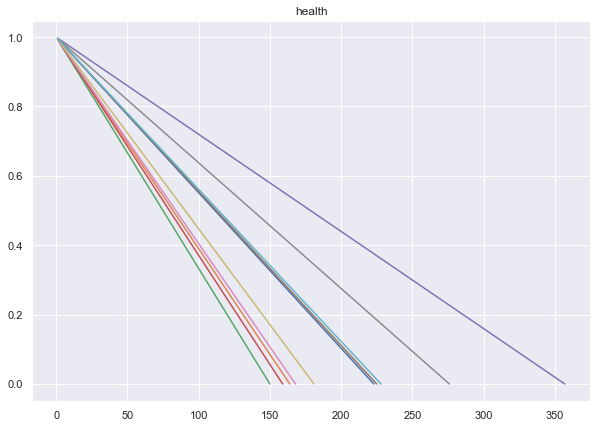

In [148]:
def vis_ensemble(data,list_sensor,nsample):
    start = data.id.unique()[0]
    for x in list_sensor:
        fig = plt.figure(figsize=(10,7))
        plt.title(x)
        for i in range(start,start+nsample):
            plt.plot(data[data.id == i].time, data[data.id == i][x])
        plt.show()
vis_ensemble(trainDataNormalized,['health'],10)

The health condition of all ensemble members change from 1 to 0 with varying degrading speeds.

Now fit a linear regression model of Health Condition with the most trended sensor measurements as regressors:
Health Condition ~ 1 + Sensor2 + Sensor3 + Sensor4 + Sensor7 + Sensor11 + Sensor12 + Sensor15 + Sensor17

In [149]:
sensorToFuse = ['sensor_2','sensor_3','sensor_4','sensor_7','sensor_11','sensor_12','sensor_15','sensor_17']
X = trainDataNormalized[sensorToFuse]
y = trainDataNormalized.health
regModel = LinearRegression()
regModel.fit(X,y)
weights = regModel.coef_
weights

array([-0.02893543, -0.03095101, -0.05318278,  0.00410429, -0.06591263,
        0.00645401, -0.04014494, -0.03822207])

Construct a single health indicator by multiplying the sensor measurements with their associated weights .

In [150]:
def degradationSensorFusion(data, sensorToFuse, weights):
    dataFused = pd.DataFrame(data = np.sum(data[sensorToFuse]*weights, axis=1), columns = ['DataFused'])
    dataFused[['id','time']] = data[['id','time']].copy()
    ids = dataFused.id.unique()
    list_df = []
    for idx in ids:
        each_idx = dataFused[dataFused.id == idx].copy()
        each_idx['DataFused'] = each_idx['DataFused'].rolling(window=21, center=True, min_periods=0).mean()
        neg = each_idx['DataFused'].values[0]
        each_idx['DataFused'] = each_idx['DataFused'] + 1 - neg
        list_df.append(each_idx)
    res_df = pd.concat(list_df)
    return res_df
trainDataFused = degradationSensorFusion(trainDataNormalized, sensorToFuse, weights)

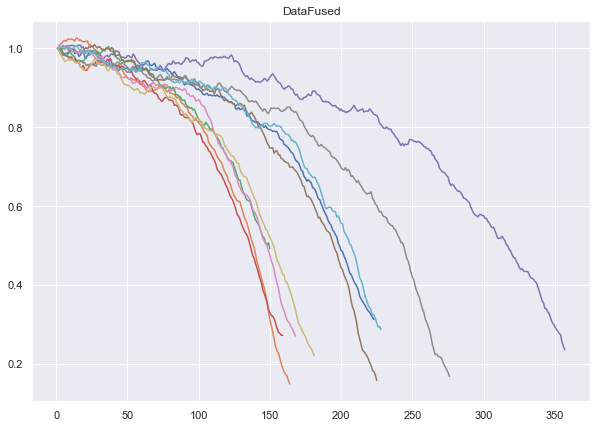

In [151]:
vis_ensemble(trainDataFused,['DataFused'],10)

# Apply same operation to validation data

In [278]:
#Predict columns for validation data
opCondition_var = validationData[conditionVariables]
y_means_var = kmeans.predict(opCondition_var)
validationData['cluster'] = y_means_var

In [279]:
validationDataNormalized = regimeNormalization(validationData)
validataionDataToFused = degradationSensorFusion(validationDataNormalized, sensorToFuse, weights)

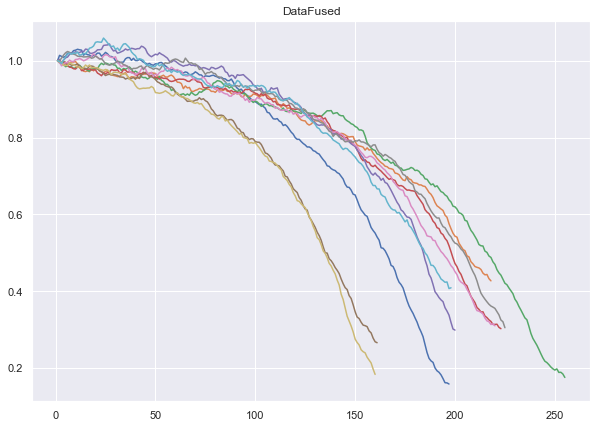

In [280]:
vis_ensemble(validataionDataToFused,['DataFused'],10)

# Build Similarity RUL Model 

### Build test model 2nd order polynomial

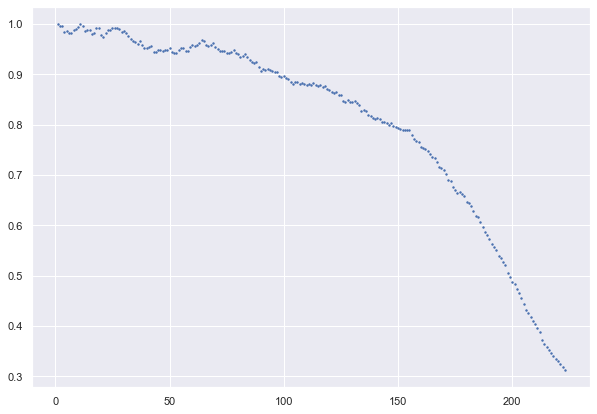

In [281]:
trainDataFused_1 = trainDataFused[trainDataFused.id == 1].copy()
fig = plt.figure(figsize=(10,7))
plt.scatter(trainDataFused_1.time, trainDataFused_1.DataFused, s=2)

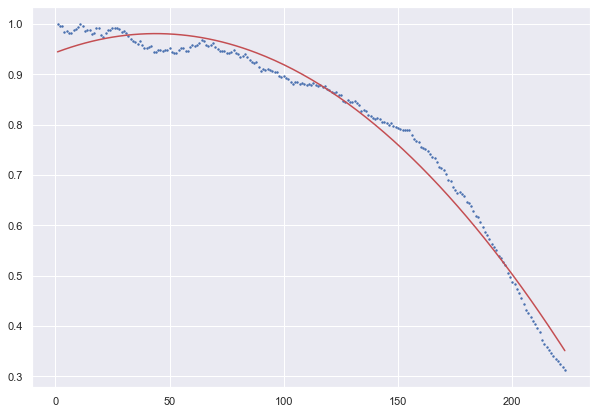

In [282]:
# fit data with a 2nd order polynomial.
p = np.polyfit(trainDataFused_1.time, trainDataFused_1.DataFused, 2)

fig = plt.figure(figsize=(10,7))
plt.scatter(trainDataFused_1.time, trainDataFused_1.DataFused, s=2, label='Train Data')
plt.plot(trainDataFused_1.time,np.polyval(p,trainDataFused_1.time), c='r', label='best fit 2nd polynomial')


### build model

In [316]:
class residualSimilarityModel:
    
    def __init__(self):
        self.df_model = pd.DataFrame(columns = ['id','lifeSpan','poly'], index=None)
    
    def fit(self, dataTrain): # data train has many machines
        ids = dataTrain.id.unique()
        for idx in ids:
            each_id = dataTrain[dataTrain.id == idx].copy()
            poly = np.polyfit(each_id.time, each_id.DataFused, 2)
            self.df_model = self.df_model.append(pd.Series({
                'id':idx,
                'lifeSpan':each_id.time.values[-1],
                'poly':poly,
            }), ignore_index = True)
            
    def predictRUL(self, dataTest): # data test is a machine
        list_score = []
        for poly in self.df_model.poly:
            d_ij = np.linalg.norm(dataTest.DataFused - np.polyval(poly, dataTest.time),ord=1)
#            score = np.exp(-d_ij**2)
#             print(score)
            list_score.append(d_ij)
        
        df_pred = self.df_model[['id','lifeSpan']].copy()
        df_pred['score'] = list_score
        df_pred.sort_values(by = 'score',inplace=True)
        df_pred = df_pred[:50]
        
        estRUL = df_pred.lifeSpan.mean() - dataTest.time.max()
        ciRUL = [df_pred.lifeSpan.min(),df_pred.lifeSpan.max()]
        
        return estRUL, ciRUL, df_pred

In [320]:
len(trainDataFused.id.unique())

175

In [321]:
model = residualSimilarityModel()
model.fit(trainDataFused)
test = validataionDataToFused[validataionDataToFused.id == 176].copy()
trueRUL = test.time.max()
test = test[:int(test.time.max()*0.7)]
trueRUL -= test.time.max()
estRUL, ciRUL, df_predict = model.predictRUL(test)
estRUL

59.44

In [322]:
df_test_pred = df_predict.sort_values(by = 'score', ascending=True)

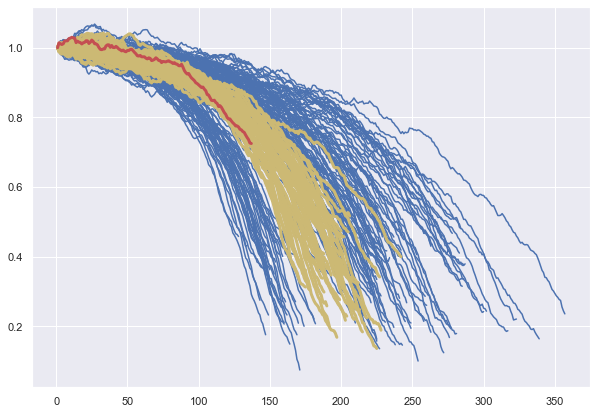

59.44

In [323]:
fig = plt.figure(figsize =(10,7))
ids = trainDataFused.id.unique()
for idx in  ids:
    each_id = trainDataFused[trainDataFused.id == idx].copy()
    plt.plot(each_id.time, each_id.DataFused, c='b')
for idx in df_test_pred.id:
    each_id = trainDataFused[trainDataFused.id == idx].copy()
    plt.plot(each_id.time, each_id.DataFused, c='y',linewidth=3)
plt.plot(test.time,test.DataFused,c='r',linewidth=3)
plt.show()
estRUL

Repeat the same evaluation procedure for the whole validation data set and compute the error between estimated RUL and true RUL for each breakpoint

In [222]:
breakpoint = {'err_5': 0.5, 'err_7': 0.7 , 'err_9': 0.9}

error = pd.DataFrame(columns = ['err_5','err_7','err_9'],index=None)

ids = validataionDataToFused.id.unique()
for idx in ids:
  
    dicIdx = {'err_5': 0, 'err_7': 0 , 'err_9':0}
    for bpIdx in breakpoint.keys():
        
        dataIdx = validataionDataToFused[validataionDataToFused.id == idx].copy()
        trueRUL = dataIdx.time.max()
        dataIdx = dataIdx[:int(dataIdx.time.max() * breakpoint[bpIdx])]
        trueRUL -= dataIdx.time.max()
        estRUL, _, _  = model.predictRUL(dataIdx)
        dicIdx[bpIdx] = estRUL - trueRUL
    error = error.append(pd.Series(dicIdx), ignore_index=True)

In [309]:
temp = validataionDataToFused[validataionDataToFused.id == np.random.choice(validataionDataToFused.id.unique())].copy()

In [313]:
242-217

25

In [310]:
temp

,DataFused,id,time
39691,1.000000,189,1
39692,0.996790,189,2
39693,0.993416,189,3
39694,0.994347,189,4
39695,0.990272,189,5
...,...,...,...
39928,0.392205,189,238
39929,0.389423,189,239
39930,0.385977,189,240
39931,0.379752,189,241


In [318]:
val_id = np.random.choice(validataionDataToFused.id.unique())
for bpIdx in breakpoint.keys():
    temp = validataionDataToFused[validataionDataToFused.id == val_id].copy()
    trueRUL = temp.time.max()
    temp = temp[:int(temp.time.max() * breakpoint[bpIdx])]
    trueRUL -= temp.time.max()
    print(model.predictRUL(temp))

(98.16, [173, 286],       id lifeSpan     score
144  145      189  1.758634
148  149      192  1.782267
99   100      213  1.883007
49    50      223  1.904611
117  118      188  1.937531
34    35      188  1.976687
168  169      218  2.000822
86    87      177  2.012238
110  111      227  2.065318
10    11      210  2.107186
65    66      190  2.110764
74    75      186  2.161321
90    91      199  2.182601
29    30      200  2.187976
12    13      210  2.212439
36    37      177  2.237680
162  163      177  2.239958
124  125      245  2.285954
80    81      199  2.351032
134  135      188  2.360703
151  152      213  2.366546
51    52      212  2.414487
161  162      202  2.441564
0      1      223  2.457839
20    21      205  2.486595
83    84      206  2.486623
133  134      173  2.488563
39    40      187  2.548900
44    45      242  2.552799
53    54      249  2.560120
67    68      204  2.563050
78    79      225  2.590184
47    48      227  2.601117
155  156      228  2.616024


In [304]:
temp

,DataFused,id,time
44018,1.000000,210,1
44019,1.000836,210,2
44020,1.000739,210,3
44021,0.999728,210,4
44022,0.992722,210,5
...,...,...,...
44246,0.367204,210,229
44247,0.357381,210,230
44248,0.355348,210,231
44249,0.352498,210,232


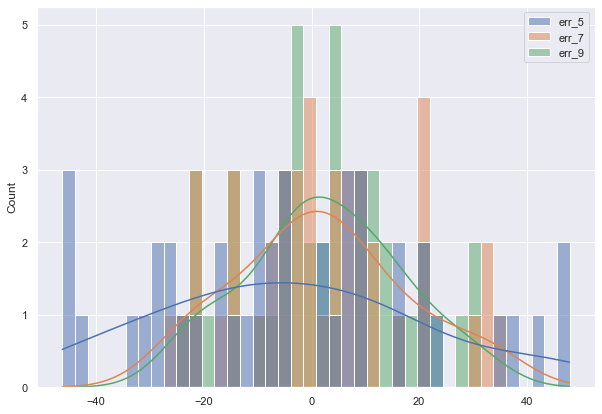

In [250]:
fig = plt.figure(figsize=(10,7))
sns.histplot(error,kde=True,bins=40)
plt.show()

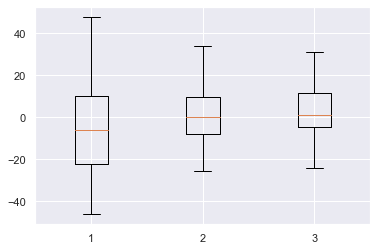

In [234]:
plt.boxplot(error)
plt.show()

In [225]:
errorMean = error.mean()
errorMean

err_5   -3.733953
err_7    1.948837
err_9    2.406977
dtype: float64

In [247]:
errorMean = error.median()
errorMean

err_5   -6.18
err_7    0.14
err_9    1.14
dtype: float64

In [249]:
errorSD = error.std()
errorSD

err_5    24.987573
err_7    15.883330
err_9    14.260763
dtype: float64

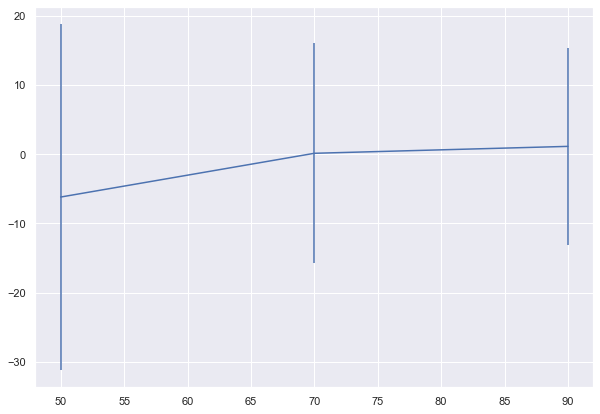

In [255]:
fig = plt.figure(figsize=(10,7))
plt.errorbar(x=[50, 70, 90], y=errorMean, yerr = errorSD)
plt.show()